In [32]:
import pandas as pd
import glob
import os
import random
import numpy as np
import cv2


In [33]:
df=pd.read_csv("../Data/data.csv")
df.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [35]:
data_map = []

for sub_dir_path in glob.glob("/workspaces/Projet_RGD/Data/kaggle_3m/*"):
    try:
        dir_name = os.path.basename(sub_dir_path)
        for filename in os.listdir(sub_dir_path):
            image_path = os.path.join(sub_dir_path, filename)
            data_map.append([dir_name, image_path])
    except Exception as e:
        print(e)

In [36]:
df1 = pd.DataFrame(data_map, columns=["patient_id", "image_path"])
df1.head()

,patient_id,image_path
0,TCGA_HT_8114_19981030,/workspaces/Projet_RGD/Data/kaggle_3m/TCGA_HT_...
1,TCGA_HT_8114_19981030,/workspaces/Projet_RGD/Data/kaggle_3m/TCGA_HT_...
2,TCGA_HT_8114_19981030,/workspaces/Projet_RGD/Data/kaggle_3m/TCGA_HT_...
3,TCGA_HT_8114_19981030,/workspaces/Projet_RGD/Data/kaggle_3m/TCGA_HT_...
4,TCGA_HT_8114_19981030,/workspaces/Projet_RGD/Data/kaggle_3m/TCGA_HT_...


In [37]:
df_imgs = df1[~df1['image_path'].str.contains("mask")]
df_masks = df1[df1['image_path'].str.contains("mask")]

# extraction dfu numéro de l'image 
BASE_LEN = 76 # index ou commence le numéro
END_IMG_LEN = 4 # nombre de chaines de caractères à éliminer de la fin du chemin de l'image
END_MASK_LEN = 9 # nombre de chaines de caractères à éliminer de la fin du chemin du mask

# trier les images et masks selon leur numéros
imgs = sorted(df_imgs["image_path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["image_path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

#vérification 
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /workspaces/Projet_RGD/Data/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_13.tif 
Path to the Mask: /workspaces/Projet_RGD/Data/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_13_mask.tif


# Creation de la data finale 

In [38]:
df_final = pd.DataFrame({
    "patient_id": df_imgs.patient_id.values,
    "image_path": imgs,
    "mask_path": masks
})

def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0

In [39]:
df_final['mask'] = df_final['mask_path'].apply(lambda x: pos_neg_diagnosis(x))

In [40]:
df_final

,patient_id,image_path,mask_path,mask
0,TCGA_HT_8114_19981030,/workspaces/Projet_RGD/Data/kaggle_3m/TCGA_HT_...,/workspaces/Projet_RGD/Data/kaggle_3m/TCGA_HT_...,0
1,TCGA_HT_8114_19981030,/workspaces/Projet_RGD/Data/kaggle_3m/TCGA_HT_...,/workspaces/Projet_RGD/Data/kaggle_3m/TCGA_HT_...,0
2,TCGA_HT_8114_19981030,/workspaces/Projet_RGD/Data/kaggle_3m/TCGA_HT_...,/workspaces/Projet_RGD/Data/kaggle_3m/TCGA_HT_...,0
3,TCGA_HT_8114_19981030,/workspaces/Projet_RGD/Data/kaggle_3m/TCGA_HT_...,/workspaces/Projet_RGD/Data/kaggle_3m/TCGA_HT_...,0
4,TCGA_HT_8114_19981030,/workspaces/Projet_RGD/Data/kaggle_3m/TCGA_HT_...,/workspaces/Projet_RGD/Data/kaggle_3m/TCGA_HT_...,0
...,...,...,...,...
3924,TCGA_HT_7690_19960312,/workspaces/Projet_RGD/Data/kaggle_3m/TCGA_HT_...,/workspaces/Projet_RGD/Data/kaggle_3m/TCGA_HT_...,0
3925,TCGA_HT_7690_19960312,/workspaces/Projet_RGD/Data/kaggle_3m/TCGA_HT_...,/workspaces/Projet_RGD/Data/kaggle_3m/TCGA_HT_...,0
3926,TCGA_HT_7690_19960312,/workspaces/Projet_RGD/Data/kaggle_3m/TCGA_HT_...,/workspaces/Projet_RGD/Data/kaggle_3m/TCGA_HT_...,0
3927,TCGA_HT_7690_19960312,/workspaces/Projet_RGD/Data/kaggle_3m/TCGA_HT_...,/workspaces/Projet_RGD/Data/kaggle_3m/TCGA_HT_...,0


In [41]:
df_final["mask"].value_counts()

mask
0    2556
1    1373
Name: count, dtype: int64

## Data Visualisation

In [42]:
import plotly.graph_objects as go  

fig = go.Figure([go.Bar(x=df_final['mask'].value_counts().index, 
                        y=df_final['mask'].value_counts(), 
                        width=[.4, .4]
                       )
                ])
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=4, opacity=0.4
                 )
fig.update_layout(title_text="Graphique du nombre des masks",
                  width=700,
                  height=550,
                  yaxis=dict(
                             title_text="Count",
                             tickmode="array",
                             titlefont=dict(size=20)
                           )
                 )
fig.update_yaxes(automargin=True)
fig.show()


In [43]:
import matplotlib.pyplot as plt


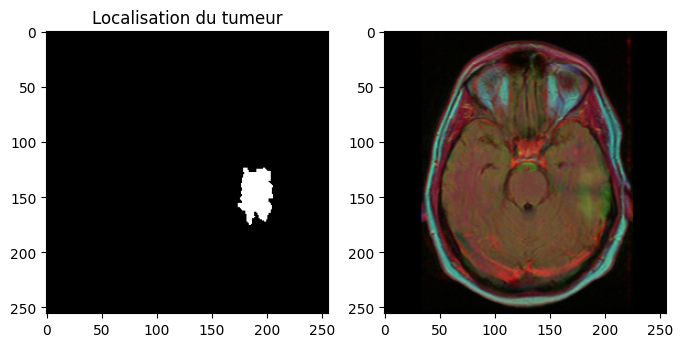

In [44]:
for i in range(len(df_final)):
    if cv2.imread(df_final.mask_path[i]).max() > 0:
        break

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(df_final.mask_path[i]));
plt.title('Localisation du tumeur')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(df_final.image_path[i]));

In [45]:
cv2.imread(df_final.mask_path[i]).max(), cv2.imread(df_final.mask_path[i]).min()

(np.uint8(255), np.uint8(0))

Les valeurs min=0 et max=255 indiquent que le masque est binaire et contient bien une région annotée. La présence de la valeur 255 confirme l’existence d’une zone tumorale sur cette image.

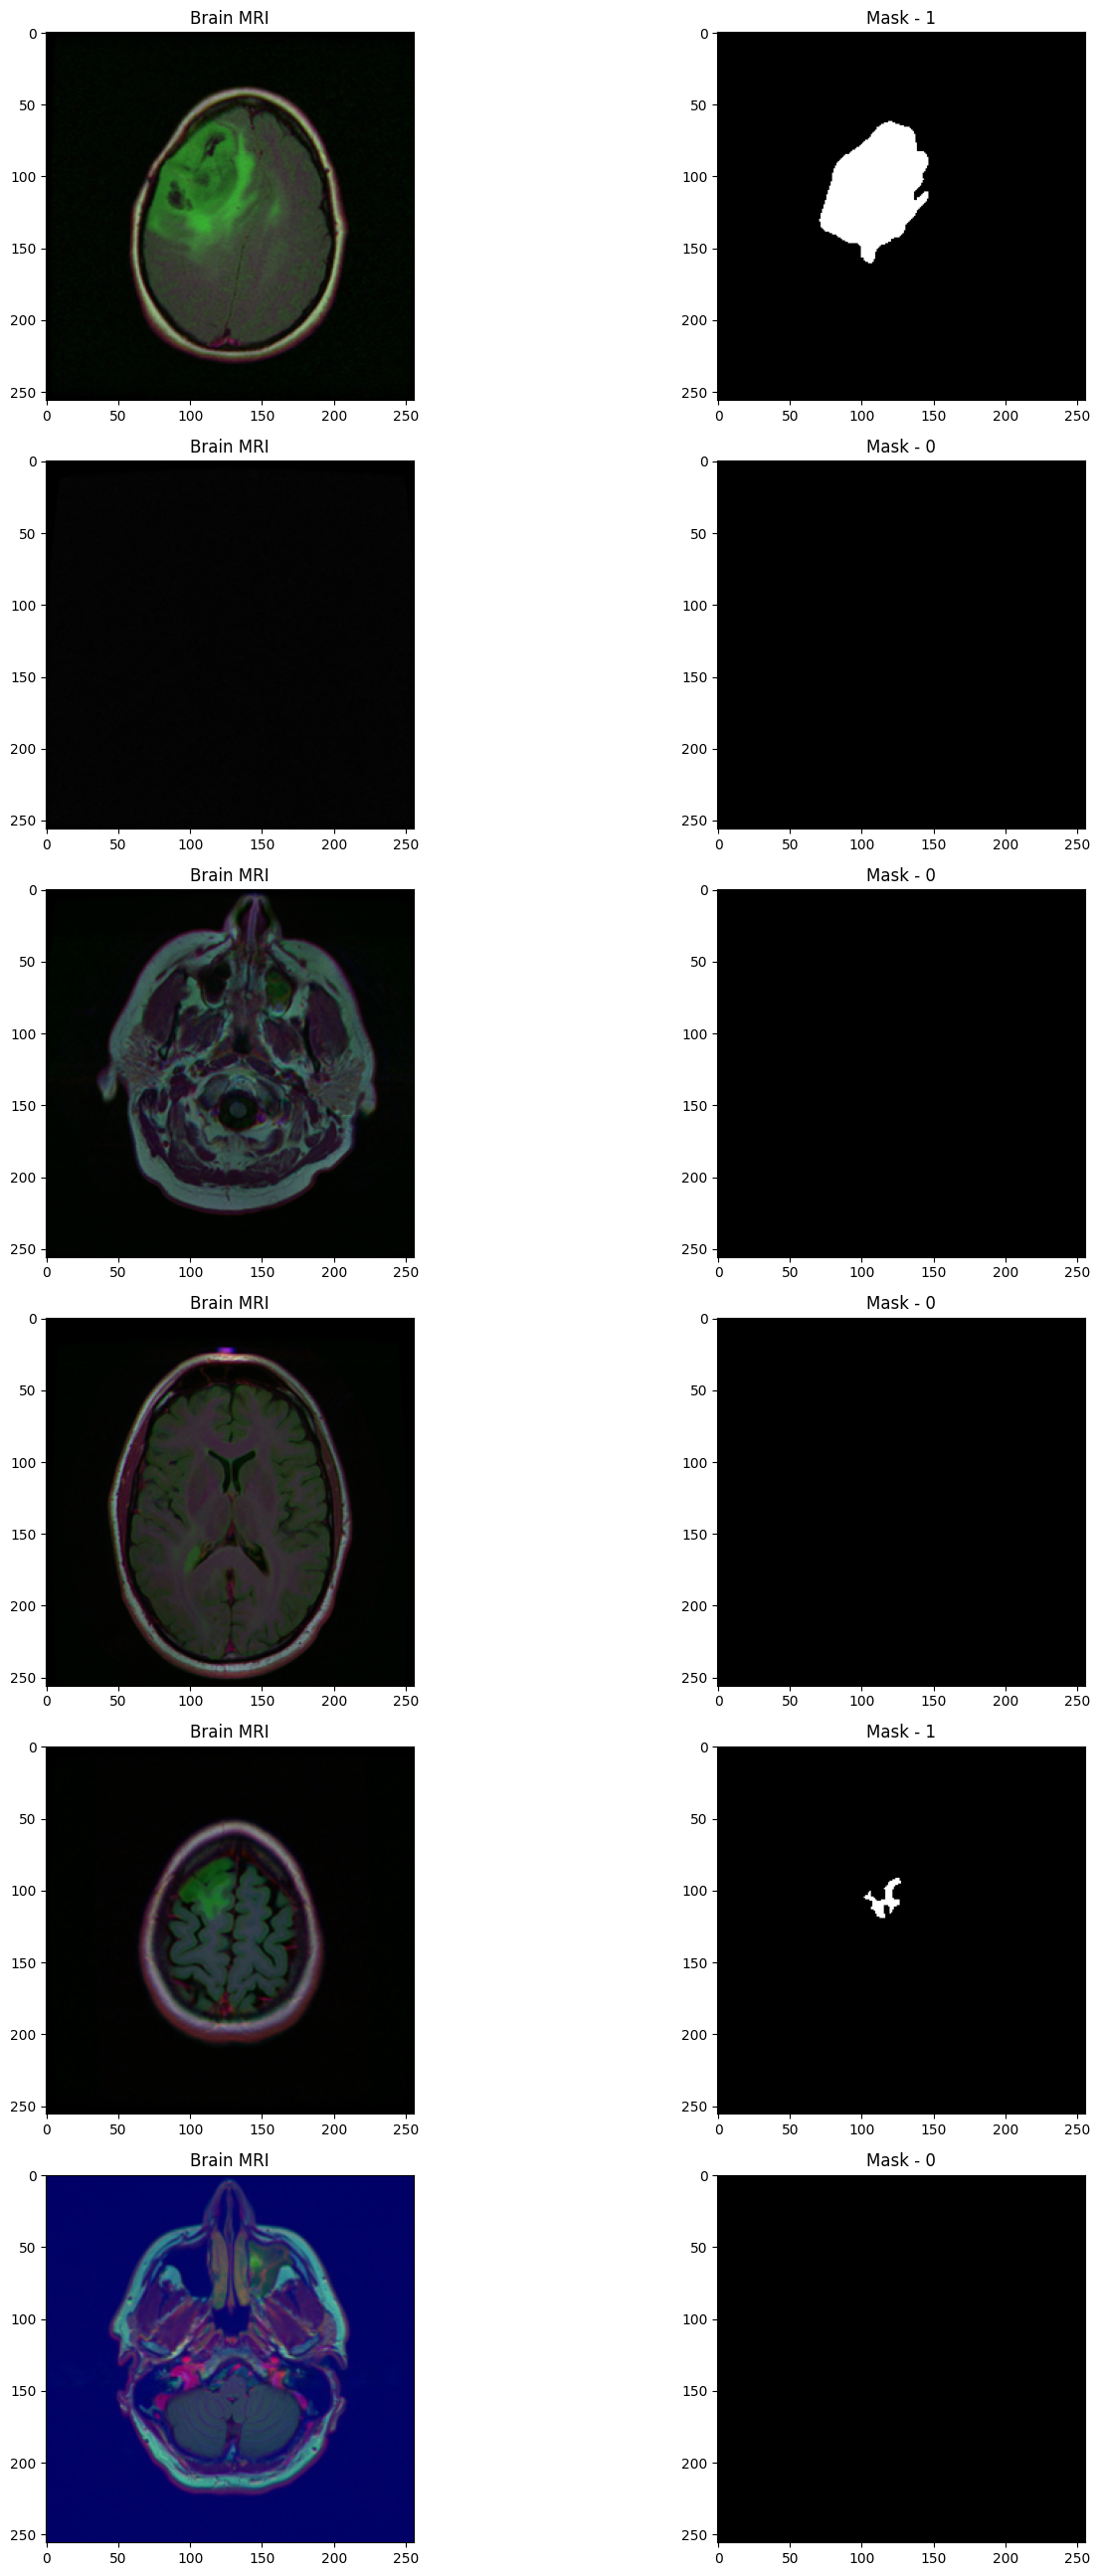

In [46]:
# Visualisations de base : afficher séparément les images (IRM et masques) du dataset
fig, axs = plt.subplots(6,2, figsize=(16,26))
count = 0
for x in range(6):
  i = random.randint(0, len(df_final)) 
  axs[count][0].title.set_text("Brain MRI") 
  axs[count][0].imshow(cv2.imread(df_final.image_path[i])) 
  axs[count][1].title.set_text("Mask - " + str(df_final['mask'][i])) 
  axs[count][1].imshow(cv2.imread(df_final.mask_path[i])) 
  count += 1

fig.tight_layout()

# Affichage des images cérébrales (IRM) et superposition des masques de tumeur

In [51]:
import cv2

img = cv2.imread(df_final.image_path[i])
mask = cv2.imread(df_final.mask_path[i], cv2.IMREAD_GRAYSCALE)  # masque en niveau de gris


In [52]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


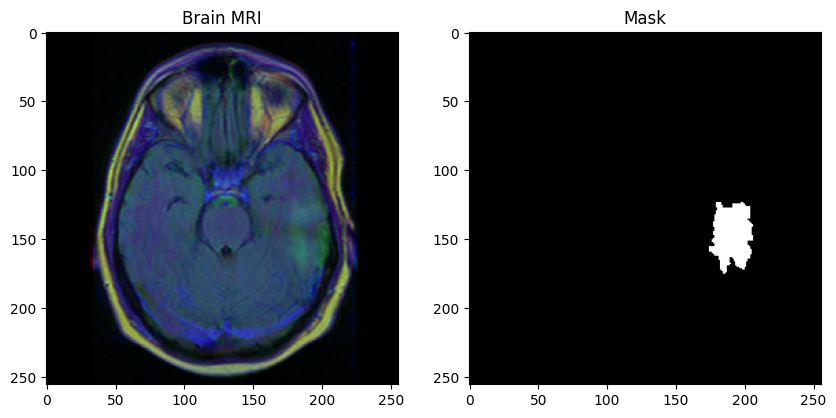

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.title("Brain MRI")

plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")

plt.show()


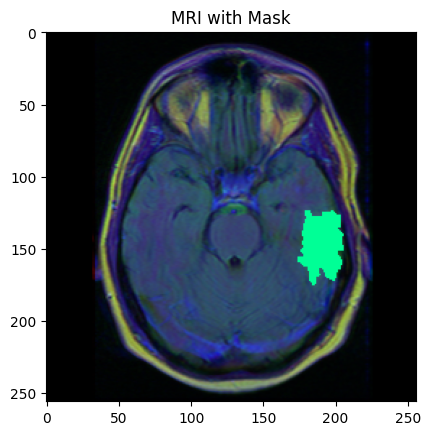

In [54]:
img_overlay = img_rgb.copy()

img_overlay[mask==255] = (0,255,150)

plt.imshow(img_overlay)
plt.title("MRI with Mask")
plt.show()
